### Spawn other objects with `Panda`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass,get_env_obj_names,set_env_obj,set_env_objs,get_env_obj_poses
from pid import PID_ControllerClass
np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


### Parse `Panda` with objects

Creating window glfw
[0/10] obj_name:[obj_box_01]
[1/10] obj_name:[obj_box_02]
[2/10] obj_name:[obj_box_03]
[3/10] obj_name:[obj_box_04]
[4/10] obj_name:[obj_box_05]
[5/10] obj_name:[obj_cylinder_01]
[6/10] obj_name:[obj_cylinder_02]
[7/10] obj_name:[obj_cylinder_03]
[8/10] obj_name:[obj_cylinder_04]
[9/10] obj_name:[obj_cylinder_05]


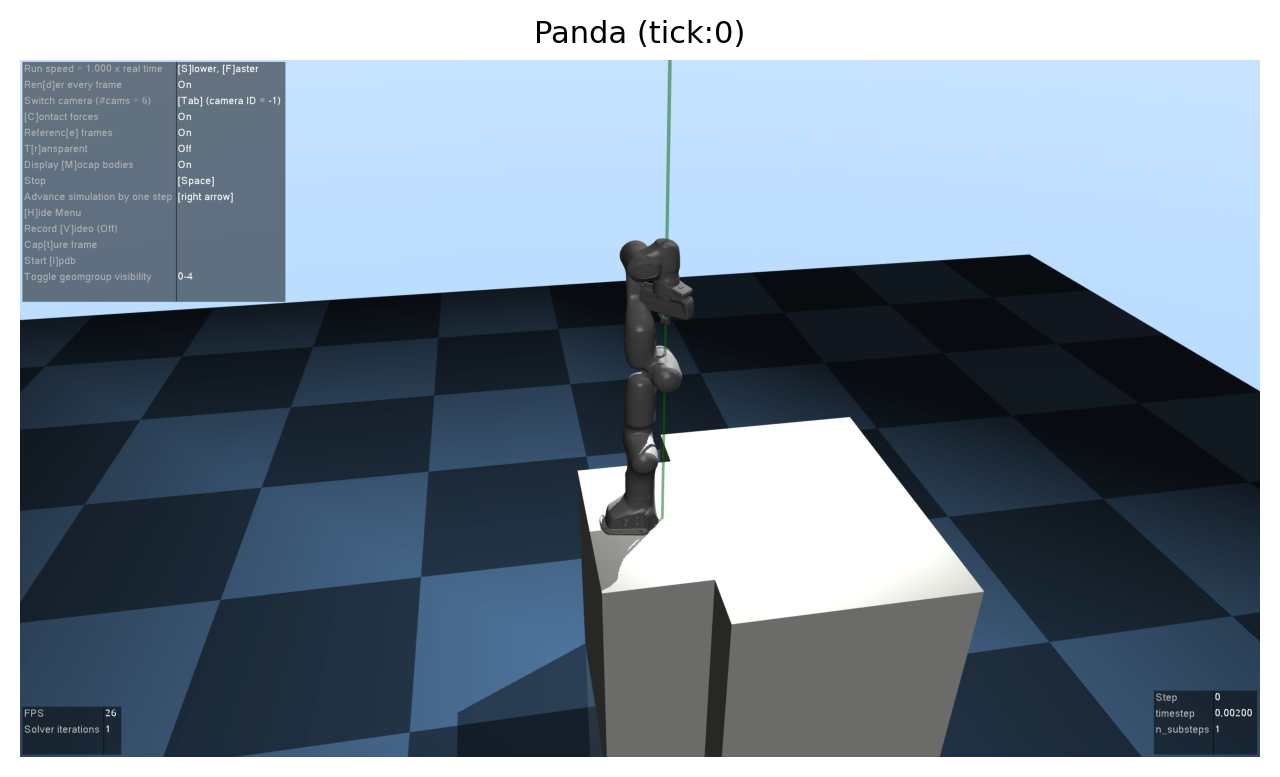

In [3]:
env = MuJoCoParserClass(name='Panda',xml_path='../asset/panda/franka_panda_w_objs.xml')
env.init_viewer(window_width=0.5,window_height=0.5,
                cam_azimuth=80.0,cam_distance=3.0,
                cam_elevation=-30.0,cam_lookat=np.array([0,0,1.5]))
# Check available objects whose names start with 'obj_'
obj_names = get_env_obj_names(env,prefix='obj_') # see objects
for obj_idx,obj_name in enumerate(obj_names):
    print ("[%d/%d] obj_name:[%s]"%(obj_idx,len(obj_names),obj_name))
env.forward_renders(max_tick=100)
env.plot_scene(figsize=(8,5),render_expand=2.0,title_str='Panda (tick:%d)'%(env.tick),title_fs=11)

### Place objects in a row with different colors 

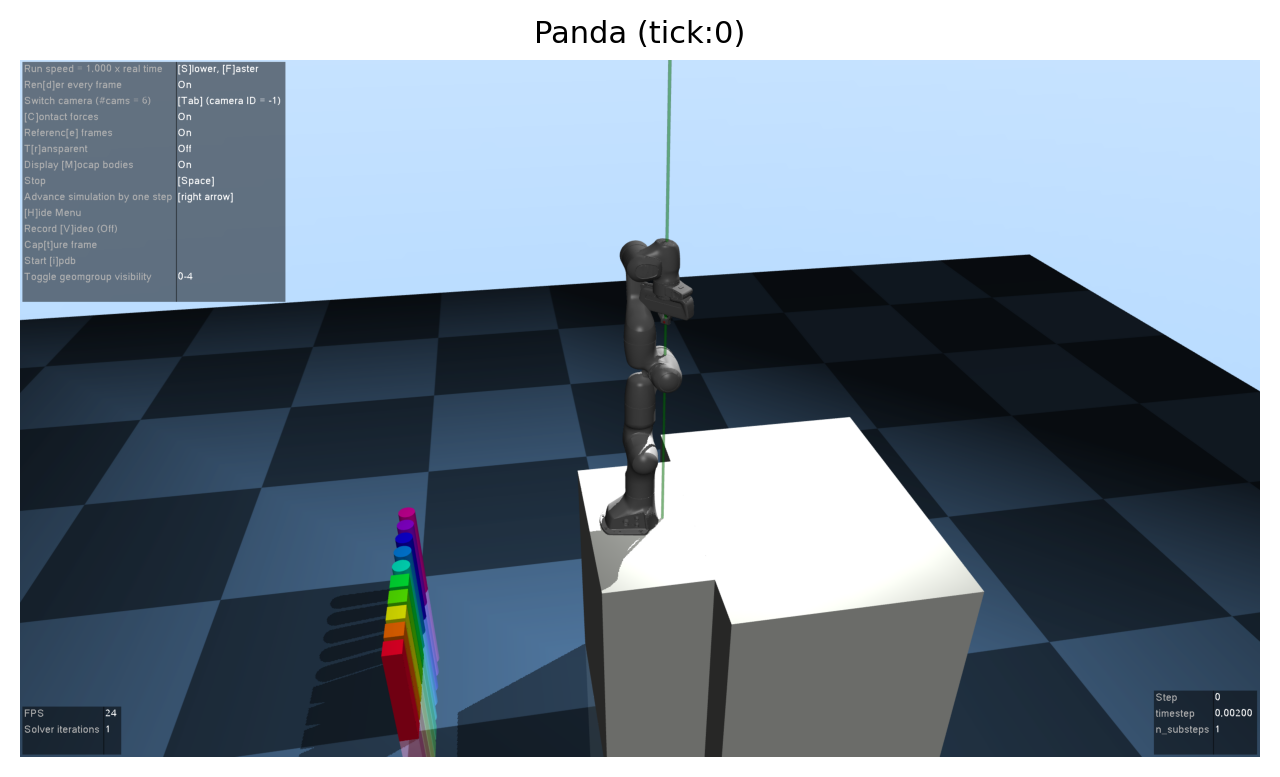

In [5]:
# Initialize position
colors = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,len(obj_names))]
for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [-1.0,0.1*obj_idx,0.0]
    obj_quat  = [0,0,0,1]
    obj_color = colors[obj_idx]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=obj_color)
env.forward(INCREASE_TICK=False) # update object locations
# Plot
env.forward_renders(max_tick=100)    
env.plot_scene(figsize=(8,5),render_expand=2.0,title_str='Panda (tick:%d)'%(env.tick),title_fs=11)    

### Randomly spawn objects on a table 

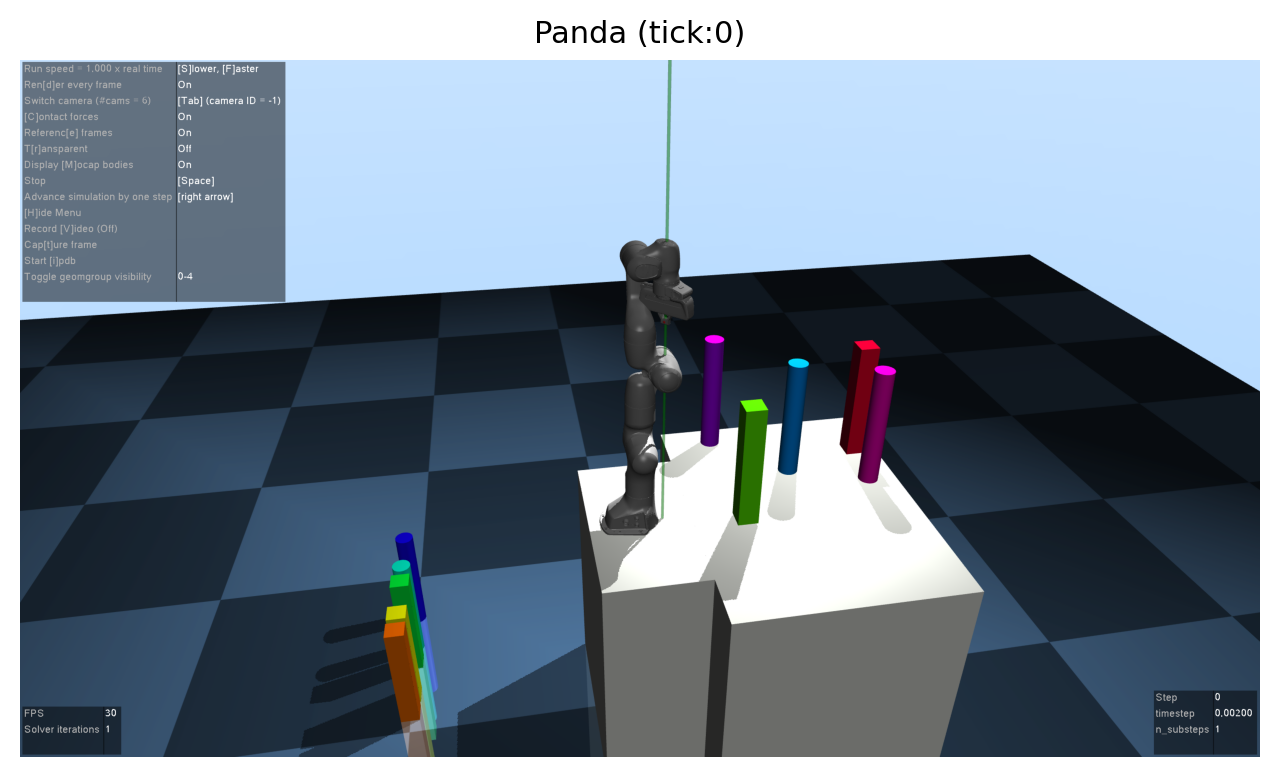

In [17]:
from scipy.spatial.distance import cdist
env.reset() # reset
# Place objects in a row on the ground
obj_names = get_env_obj_names(env,prefix='obj_') # available objects
colors = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,len(obj_names))]
for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [-1.0,0.1*obj_idx,0.0]
    obj_quat  = [0,0,0,1]
    obj_color = colors[obj_idx]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=obj_color)
env.forward(INCREASE_TICK=False) # update object locations
# Randomly place objects on the table
n_place  = 5
x_range  = [0.3,1.0]
y_range  = [-0.5,0.5]
z_range  = [1.01,1.01]
min_dist = 0.15
obj2place_idxs = np.random.permutation(len(obj_names))[:n_place].astype(int)
obj2place_names = [obj_names[o_idx] for o_idx in obj2place_idxs]
obj2place_poses = np.zeros((n_place,3))
for o_idx in range(n_place):
    while True:
        x = np.random.uniform(low=x_range[0],high=x_range[1])
        y = np.random.uniform(low=y_range[0],high=y_range[1])
        z = np.random.uniform(low=z_range[0],high=z_range[1])
        xyz = np.array([x,y,z])
        if o_idx >= 1:
            devc = cdist(xyz.reshape((-1,3)),obj2place_poses[:o_idx,:].reshape((-1,3)),'euclidean')
            if devc.min() > min_dist: break # minimum distance between objects
        else:
            break
    obj2place_poses[o_idx,:] = xyz
set_env_objs(env,obj_names=obj2place_names,obj_poses=obj2place_poses,obj_colors=None)
env.forward_renders()
env.plot_scene(figsize=(8,5),render_expand=2.0,title_str='Panda (tick:%d)'%(env.tick),title_fs=11)    

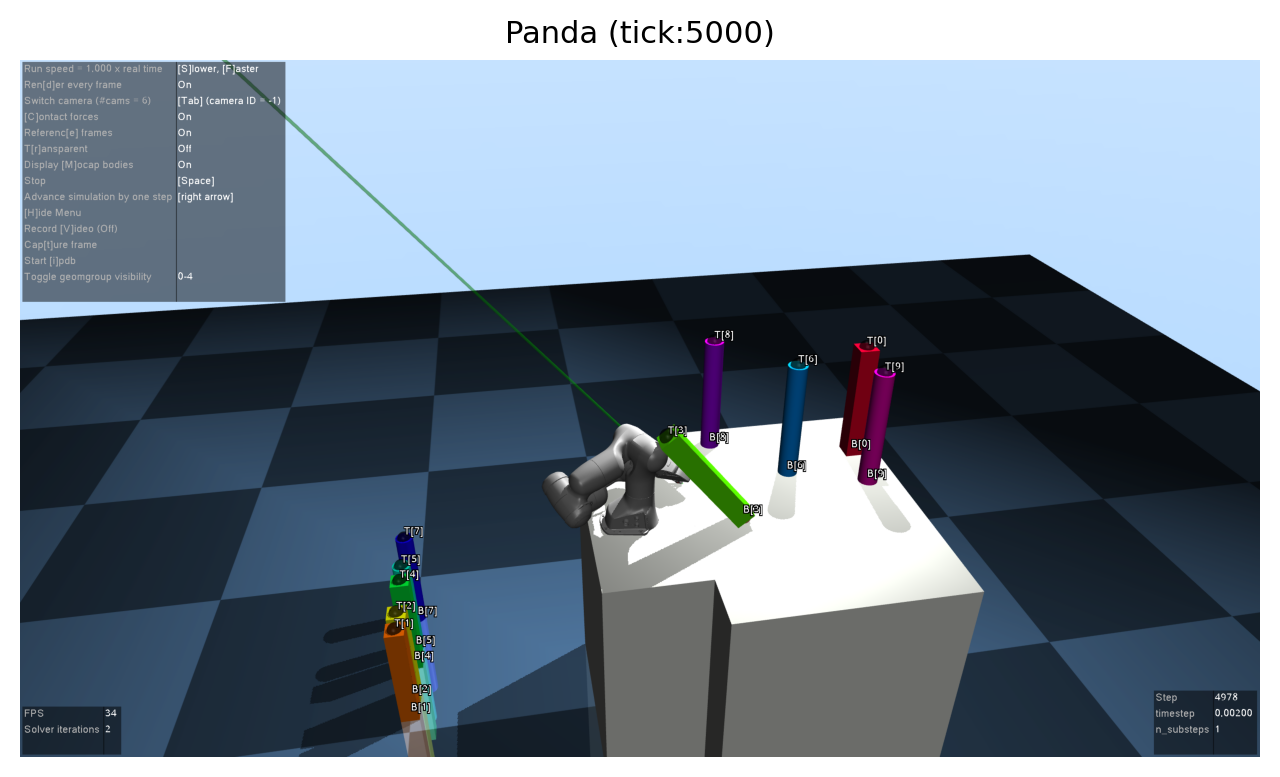

Done.


In [18]:
max_tick = 5000
while env.tick < max_tick:
    # Update
    env.step()
    # Get object poses (p and R)
    obj_ps,obj_Rs = get_env_obj_poses(env,obj_names)
    for o_idx,obj_name in enumerate(obj_names): # plot objects
        obj_p,obj_R = obj_ps[o_idx,:],obj_Rs[o_idx,:,:]
        # Bottom:red sphere, Top:black sphere
        env.add_marker(pos=obj_p,radius=0.03,color=[1,0,0,0.5],label='B[%d]'%(o_idx))
        env.add_marker(pos=obj_p+0.5*obj_R[:,2],radius=0.03,color=[0,0,0,0.5],label='T[%d]'%(o_idx))
    # Render
    env.render()
# Plot the final scene with the same viewer information
viewer_info = env.get_viewer_info() # get the last viewer information
env.plot_scene(figsize=(8,5),render_expand=2.0,title_str='Panda (tick:%d)'%(env.tick),title_fs=11)
print ("Done.")

### Terminate viewer

In [19]:
env.terminate_viewer()
print ("Viewer terminated.")

Viewer terminated.
